# Big Mart Sales Prediction 

In [4]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from scipy.stats import mode
import matplotlib.pyplot as plt
%matplotlib inline

#Read files:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

## Data Exploration

In [5]:
train.shape, test.shape

((8523, 12), (5681, 11))

In [6]:
train.columns

Index(['Item_Identifier', 'Item_Weight', 'Item_Fat_Content', 'Item_Visibility',
       'Item_Type', 'Item_MRP', 'Outlet_Identifier',
       'Outlet_Establishment_Year', 'Outlet_Size', 'Outlet_Location_Type',
       'Outlet_Type', 'Item_Outlet_Sales'],
      dtype='object')

In [7]:
test.columns

Index(['Item_Identifier', 'Item_Weight', 'Item_Fat_Content', 'Item_Visibility',
       'Item_Type', 'Item_MRP', 'Outlet_Identifier',
       'Outlet_Establishment_Year', 'Outlet_Size', 'Outlet_Location_Type',
       'Outlet_Type'],
      dtype='object')

In [8]:
train['source'] = 'train'
test['source'] = 'test'
test['Item_Outlet_Sales'] = 0
data = pd.concat([train, test], sort = False)
print(train.shape, test.shape, data.shape)


(8523, 13) (5681, 13) (14204, 13)


In [9]:
data.apply(lambda x: sum(x.isnull()))

Item_Identifier                 0
Item_Weight                  2439
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  4016
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
source                          0
dtype: int64

##### Only Item_Weight  and  Outlet_Size have missing values. These can be imputed during the Data Cleaning process.

In [10]:
data.describe()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,11765.000000,14204.000000,14204.000000,14204.000000,14204.000000
mean,12.792854,0.065953,141.004977,1997.830681,1308.865489
std,4.652502,0.051459,62.086938,8.371664,1699.791423
min,4.555000,0.000000,31.290000,1985.000000,0.000000
25%,8.710000,0.027036,94.012000,1987.000000,0.000000
50%,12.600000,0.054021,142.247000,1999.000000,559.272000
75%,16.750000,0.094037,185.855600,2004.000000,2163.184200
max,21.350000,0.328391,266.888400,2009.000000,13086.964800


#### Some observations which could be made:

#Item_Visibility has a min value of zero. This makes no practical sense because when a product is being sold in a store, the visibility cannot be 0.

#Outlet_Establishment_Years vary from 1985 to 2009. The values might not be apt in this form. Rather, if we can convert them to how old the particular store is, it should have a better impact on sales.

In [11]:
data['Outlet_Establishment_Year'].value_counts()

1985    2439
1987    1553
1999    1550
1997    1550
2004    1550
2002    1548
2009    1546
2007    1543
1998     925
Name: Outlet_Establishment_Year, dtype: int64

In [12]:
data.apply(lambda x: len(x.unique()))

Item_Identifier               1559
Item_Weight                    416
Item_Fat_Content                 5
Item_Visibility              13006
Item_Type                       16
Item_MRP                      8052
Outlet_Identifier               10
Outlet_Establishment_Year        9
Outlet_Size                      4
Outlet_Location_Type             3
Outlet_Type                      4
Item_Outlet_Sales             3494
source                           2
dtype: int64

In [13]:
data['Item_Outlet_Sales'].describe()

count    14204.000000
mean      1308.865489
std       1699.791423
min          0.000000
25%          0.000000
50%        559.272000
75%       2163.184200
max      13086.964800
Name: Item_Outlet_Sales, dtype: float64

##### Lets start looking Outlet_Size, Outlet_Location_Type, and Outlet_Type distribution in Item_Outlet_Sale

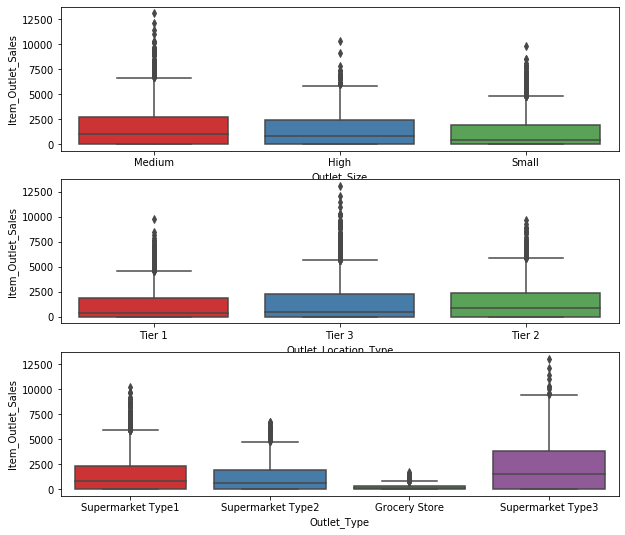

In [14]:
plt.figure(figsize = (10,9))


plt.subplot(311)
sns.boxplot(x='Outlet_Size', y='Item_Outlet_Sales', data=data, palette="Set1")

plt.subplot(312)
sns.boxplot(x='Outlet_Location_Type', y='Item_Outlet_Sales', data=data, palette="Set1")

plt.subplot(313)
sns.boxplot(x='Outlet_Type', y='Item_Outlet_Sales', data=data, palette="Set1")

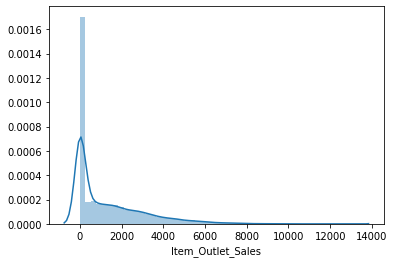

In [15]:
sns.distplot(data['Item_Outlet_Sales'])

In [16]:
print('Skewness: %f' % data['Item_Outlet_Sales'].skew())
print('Kurtsis: %f' %data['Item_Outlet_Sales'].kurt())

Skewness: 1.544684
Kurtsis: 2.419439


## Data Cleaning


Impute the missing values in Item_Weight by the average weight of the particular item.

In [17]:
item_avg_weight = data.pivot_table(values='Item_Weight', index='Item_Identifier')

missing_values = data['Item_Weight'].isnull()
print('Missing values: %d' %sum(missing_values))

data.loc[missing_values,'Item_Weight']  = data.loc[missing_values,'Item_Identifier'].apply(lambda x: item_avg_weight.at[x,'Item_Weight'])
print('Missing values after immputation %d' %sum(data['Item_Weight'].isnull()))

Missing values: 2439
Missing values after immputation 0


Impute the missing values in Outlet_Size by the mode of the same.

In [18]:
outlet_size_mode = data.pivot_table(values='Outlet_Size', columns='Outlet_Type',aggfunc=(lambda x:mode(x).mode[0]) )
print("Mode for each Outlet_Type:")
print(outlet_size_mode)


Mode for each Outlet_Type:
Outlet_Type Grocery Store Supermarket Type1 Supermarket Type2  \
Outlet_Size         Small             Small            Medium   

Outlet_Type Supermarket Type3  
Outlet_Size            Medium  


#### Now, there are no missing values 

##### We saw that there's some typos and difference in representation in categories of Item_Fat_Content variable. Low Fat is represented by lf, low fat, Low Fat and Regular is also represented as reg etc. This should be corrected as:

In [19]:
#Change categories of low fat:
print('Original Categories:')
print(data['Item_Fat_Content'].value_counts())

print('\nModified Categories:')
data['Item_Fat_Content'] = data['Item_Fat_Content'].replace({'LF':'Low Fat',
                                                             'reg':'Regular',
                                                             'low fat':'Low Fat'})
print(data['Item_Fat_Content'].value_counts())


Original Categories:
Low Fat    8485
Regular    4824
LF          522
reg         195
low fat     178
Name: Item_Fat_Content, dtype: int64

Modified Categories:
Low Fat    9185
Regular    5019
Name: Item_Fat_Content, dtype: int64


## Feature Engineering

We saw during the data exploration that minimum value of Item_Visibility is 0, which is impractical.So, we consider it like missing information and impute it with mean visibility of that product.

In [20]:
#Determine average visibility of a product
visibility_avg = data.pivot_table(values='Item_Visibility', index='Item_Identifier')

#Impute 0 values with mean visibility of that product:
missing_values = (data['Item_Visibility'] == 0)

print ('Number of 0 values initially: %d'%sum(missing_values))
data.loc[missing_values,'Item_Visibility'] = data.loc[missing_values,'Item_Identifier'].apply(lambda x: visibility_avg.at[x, 'Item_Visibility'])
print ('Number of 0 values after modification: %d'%sum(data['Item_Visibility'] == 0))

Number of 0 values initially: 879
Number of 0 values after modification: 0


#### Now there are no '0' values

### Create a broad category of Item_type

###### We saw that there are 16 types of Item, but there is a catch every item has a unique ID i.e Item_Identifier and the Item_Identifier starts with either 'FD', 'NC'or 'DR'. And hence, we combine the each type together as follows:
FC = Food
NC = Non-Consumables
DR = Drinks 

In [21]:
#Get the first two characters of Item_Identifier:
data['Item_Type_Combined'] = data['Item_Identifier'].apply(lambda x: x[0:2])
#Rename them to more intuitive categories:
data['Item_Type_Combined'] = data['Item_Type_Combined'].map({'FD':'Food',
                                                             'NC':'Non-Consumable',
                                                             'DR':'Drinks'})
data['Item_Type_Combined'].value_counts()


Food              10201
Non-Consumable     2686
Drinks             1317
Name: Item_Type_Combined, dtype: int64

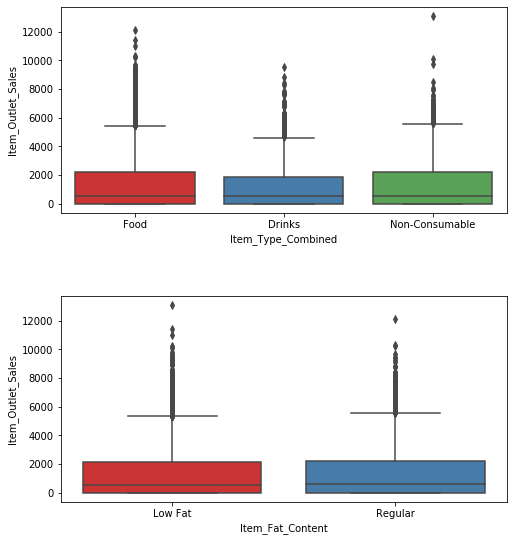

In [22]:
plt.figure(figsize = (8,5))

plt.subplot(211)
sns.boxplot(x='Item_Type_Combined', y='Item_Outlet_Sales', data=data, palette="Set1")

plt.subplot(212)
sns.boxplot(x='Item_Fat_Content', y='Item_Outlet_Sales', data=data, palette="Set1")

plt.subplots_adjust(wspace = 0.2, hspace = 0.4,top = 1.5)

plt.show()

####  Numerical and One-Hot Coding of Categorical variables

Since scikit-learn accepts only numerical variables, convert all categories of nominal variables into numeric types.
One-Hot-Coding refers to creating dummy variables, one for each category of a categorical variable. For example, the Item_Fat_Content has 2 categories – ‘Low Fat’and ‘Regular’. One hot coding will remove this variable and generate 2 new variables. Each will have binary numbers – 0 (if the category is not present) and 1(if category is present). This can be done using ‘get_dummies’ function of Pandas.

In [ ]:
#Import library:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
le = LabelEncoder()
#New variable for outlet
data['Outlet'] = le.fit_transform(data['Outlet_Identifier'])
var_mod = ['Item_Fat_Content','Outlet_Location_Type','Outlet_Size','Item_Type_Combined','Outlet_Type','Outlet']
le = LabelEncoder()
for i in var_mod:
    data[i] = le.fit_transform(data[i])

In [73]:
#One Hot Coding:
data = pd.get_dummies(data, columns=['Item_Fat_Content','Outlet_Location_Type','Outlet_Size','Outlet_Type',
                              'Item_Type_Combined','Outlet'])

KeyError: "['Outlet_Size', 'Item_Type_Combined', 'Outlet_Location_Type', 'Outlet_Type', 'Item_Fat_Content'] not in index"

In [74]:
data.dtypes

Item_Identifier                       object
Item_Weight                          float64
Item_Visibility                      float64
Item_MRP                             float64
Outlet_Identifier                     object
Item_Outlet_Sales                    float64
source                                object
Item_Fat_Content_0                     uint8
Item_Fat_Content_1                     uint8
Outlet_Location_Type_0                 uint8
Outlet_Location_Type_1                 uint8
Outlet_Location_Type_2                 uint8
Outlet_Size_High                       uint8
Outlet_Size_Medium                     uint8
Outlet_Size_Small                      uint8
Outlet_Type_Grocery Store              uint8
Outlet_Type_Supermarket Type1          uint8
Outlet_Type_Supermarket Type2          uint8
Outlet_Type_Supermarket Type3          uint8
Item_Type_Combined_Drinks              uint8
Item_Type_Combined_Food                uint8
Item_Type_Combined_Non-Consumable      uint8
Outlet_0  

In [75]:
data[['Item_Fat_Content_0','Item_Fat_Content_1']].head(10)

,Item_Fat_Content_0,Item_Fat_Content_1
0,1,0
1,0,1
2,1,0
3,0,1
4,1,0
5,0,1
6,0,1
7,1,0
8,0,1
9,0,1


You can notice that each row will have only one of the columns as 1 corresponding to the category in the original variable.

### Exporting Data

##### Final step is to convert data back into train and test data sets. Its generally a good idea to export both of these as modified data sets so that they can be re-used for multiple sessions. This can be achieved using following code:

In [76]:
#Drop the columns which have been converted to different types and item which do not affect much:
data.drop(['Item_Type','Outlet_Establishment_Year'],axis=1,inplace=True)

#Divide into test and train:
train = data.loc[data['source']=="train"]
test = data.loc[data['source']=="test"]

#Drop unnecessary columns:
test.drop(['Item_Outlet_Sales','source'],axis=1,inplace=True)
train.drop(['source'],axis=1,inplace=True)

#Export files as modified versions:
train.to_csv("train_modified.csv",index=False)
test.to_csv("test_modified.csv",index=False)

KeyError: "['Item_Type' 'Outlet_Establishment_Year'] not found in axis"

#### Now the data is ready for Model Building

## Model Building

In [77]:
# Reading modified data
train2 = pd.read_csv("train_modified.csv")
test2 = pd.read_csv("test_modified.csv")


In [78]:
train2.head()

,Item_Identifier,Item_Weight,Item_Visibility,Item_MRP,Outlet_Identifier,Item_Outlet_Sales,Item_Fat_Content_0,Item_Fat_Content_1,Outlet_Location_Type_0,Outlet_Location_Type_1,...,Outlet_0,Outlet_1,Outlet_2,Outlet_3,Outlet_4,Outlet_5,Outlet_6,Outlet_7,Outlet_8,Outlet_9
0,FDA15,9.30,0.016047,249.8092,OUT049,3735.1380,1,0,1,0,...,0,0,0,0,0,0,0,0,0,1
1,DRC01,5.92,0.019278,48.2692,OUT018,443.4228,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0
2,FDN15,17.50,0.016760,141.6180,OUT049,2097.2700,1,0,1,0,...,0,0,0,0,0,0,0,0,0,1
3,FDX07,19.20,0.017834,182.0950,OUT010,732.3800,0,1,0,0,...,1,0,0,0,0,0,0,0,0,0
4,NCD19,8.93,0.009780,53.8614,OUT013,994.7052,1,0,0,0,...,0,1,0,0,0,0,0,0,0,0


In [79]:
X_train = train2.drop(['Item_Outlet_Sales', 'Outlet_Identifier','Item_Identifier'], axis=1)
y_train = train2.Item_Outlet_Sales

In [80]:
X_test = test2.drop(['Outlet_Identifier','Item_Identifier'], axis=1)
X_train.head()

,Item_Weight,Item_Visibility,Item_MRP,Item_Fat_Content_0,Item_Fat_Content_1,Outlet_Location_Type_0,Outlet_Location_Type_1,Outlet_Location_Type_2,Outlet_Size_High,Outlet_Size_Medium,...,Outlet_0,Outlet_1,Outlet_2,Outlet_3,Outlet_4,Outlet_5,Outlet_6,Outlet_7,Outlet_8,Outlet_9
0,9.30,0.016047,249.8092,1,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
1,5.92,0.019278,48.2692,0,1,0,0,1,0,1,...,0,0,0,1,0,0,0,0,0,0
2,17.50,0.016760,141.6180,1,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
3,19.20,0.017834,182.0950,0,1,0,0,1,0,0,...,1,0,0,0,0,0,0,0,0,0
4,8.93,0.009780,53.8614,1,0,0,0,1,1,0,...,0,1,0,0,0,0,0,0,0,0


In [81]:
y_train.head()


0    3735.1380
1     443.4228
2    2097.2700
3     732.3800
4     994.7052
Name: Item_Outlet_Sales, dtype: float64

#### Let's first explore how Linear Regression is working
### Linear Regression Model

In [82]:
from sklearn.linear_model import  LinearRegression
regressor = LinearRegression()
regressor.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [83]:
# Predicting the test set results
y_pred = regressor.predict(X_test)
y_pred

array([1847.88833294, 1569.34039507, 1875.61463945, ..., 1809.35593931,
       3539.0001027 , 1266.59119677])

In [84]:
import warnings
warnings.filterwarnings('ignore')
# Measuring Accuracy
from sklearn.metrics import accuracy_score, r2_score, mean_squared_error
from sklearn.model_selection import cross_val_score




In [85]:

lr_accuracy = round(regressor.score(X_train,y_train) * 100,2)
lr_accuracy

56.35

In [86]:
r2_score(y_train, regressor.predict(X_train))

0.5634742545808915

In [87]:
print("RMSE : %.4g" % np.sqrt(metrics.mean_squared_error(y_train, regressor.predict(X_train))))

RMSE : 1127


In [88]:
submission = pd.DataFrame({
'Item_Identifier':test2['Item_Identifier'],
'Outlet_Identifier':test2['Outlet_Identifier'],
'Item_Outlet_Sales': y_pred
},columns=['Item_Identifier','Outlet_Identifier','Item_Outlet_Sales'])

submission.to_csv('submissionLR.csv',index=False)


### Decision Tree Model

#### Let's see if this model improves the accuracy or not.

In [89]:
# Fitting Decision Tree Regression to the dataset
from sklearn.tree import DecisionTreeRegressor
regressor = DecisionTreeRegressor(max_depth=15,min_samples_leaf=300)
regressor.fit(X_train, y_train)

DecisionTreeRegressor(criterion='mse', max_depth=15, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=300,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')

In [90]:
# Predicting the test set results
y_pred = regressor.predict(X_test)
y_pred

array([1673.98398729, 1349.51290433,  471.30684669, ..., 1892.06614452,
       3845.49167395, 1349.51290433])

In [91]:
tree_accuracy = round(regressor.score(X_train,y_train),2)
tree_accuracy


0.59

In [92]:

r2_score(y_train, regressor.predict(X_train))

0.5883920698327848

In [93]:
print("RMSE : %.4g" % np.sqrt(metrics.mean_squared_error(y_train, regressor.predict(X_train))))

RMSE : 1095


#### Accuracy as well as RMSE has improved, for obvious reasons.

### Random Forest Model
#### Let's see the improvements which random forest model brings out.

In [94]:
# Fitting Random Forest Regression to the dataset
from sklearn.ensemble import RandomForestRegressor
regressor = RandomForestRegressor(n_estimators=100,max_depth=6, min_samples_leaf=50,n_jobs=4)
regressor.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=6,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=50, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=4,
                      oob_score=False, random_state=None, verbose=0,
                      warm_start=False)

In [95]:
# Predicting the test set results
y_pred = regressor.predict(X_test)
y_pred

array([1647.00701153, 1359.01897004,  609.46618594, ..., 1946.95860653,
       3634.79034105, 1288.81240336])

In [96]:
rf_accuracy = round(regressor.score(X_train,y_train),2)
rf_accuracy

0.61

In [97]:
r2_score(y_train, regressor.predict(X_train))

0.6129692862494395

In [98]:
print("RMSE : %.4g" % np.sqrt(metrics.mean_squared_error(y_train, regressor.predict(X_train))))

RMSE : 1062


In [99]:
submission = pd.DataFrame({
'Item_Identifier':test2['Item_Identifier'],
'Outlet_Identifier':test2['Outlet_Identifier'],
'Item_Outlet_Sales': y_pred
},columns=['Item_Identifier','Outlet_Identifier','Item_Outlet_Sales'])


submission.to_csv('submissionRF.csv',index=False)

#### Undoubtedly, Random Forest Model works better than Decision Tree and Linear Regression, but it may not be the best solution out there.
